# Autonomous Driving - Car Detection

In [1]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Input, Lambda, Conv2D
from tensorflow.python.keras.models import load_model, Model
from yad2k.utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.yolo_v2 import yolo_head, boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body, filter_boxes, yolo_eval
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os

## Problem Statement

We are working on a self-driving car. We'd like to first build a car detection system. To collect data, we've mounted a camera to the hood (meaning the front) of the car, which takes pictures of the road ahead every few seconds while we drive around. 

We've gathered all these images into a folder and have labelled them by drawing bounding boxes around every car we found. Here's an example of what our bounding boxes look like.

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1559832273/box_label.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</b></u>: <b>Definition of a box</b><br> </center></caption>

If we have 80 classes that we want YOLO to recognize, we can represent the class label $c$ either as an integer from 1 to 80, or as an 80-dimensional vector (with 80 numbers) one component of which is 1 and the rest of which are 0.

## YOLO

YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.

### Model details

First things to know:
- The **input** is a batch of images of shape (m, 608, 608, 3)
- The **output** is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers $(p_c, b_x, b_y, b_h, b_w, c)$ as explained above. If we expand $c$ into an 80-dimensional vector, each bounding box is then represented by 85 numbers. 

We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

Lets look in greater detail at what this encoding represents. 

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1559832272/architecture.png" style="width:700px;height:400;">
<caption><center> <u> <b>Figure 2</b></u>: <b>Encoding architecture for YOLO</b><br> </center></caption>

If the center/midpoint of an object falls into a grid cell, that grid cell is responsible for detecting that object.

Since we are using 5 anchor boxes, each of the 19 x19 cells thus encodes information about 5 boxes. Anchor boxes are defined only by their width and height.

For simplicity, we will flatten the last two last dimensions of the shape (19, 19, 5, 85) encoding. So the output of the Deep CNN is (19, 19, 425).

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1559832263/flatten.png" style="width:700px;height:400;">
<caption><center> <u><b>Figure 3</b> </u>: <b>Flattening the last two last dimensions</b><br> </center></caption>

Now, for each box (of each cell) we will compute the following elementwise product and extract a probability that the box contains a certain class.

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1559832263/probability_extraction.png" style="width:700px;height:400;">
<caption><center> <u><b>Figure 4</b></u>: <b>Find the class detected by each box</b><br> </center></caption>

Here's one way to visualize what YOLO is predicting on an image:
- For each of the 19x19 grid cells, find the maximum of the probability scores (taking a max across both the 5 anchor boxes and across different classes). 
- Color that grid cell according to what object that grid cell considers the most likely.

Doing this results in this picture: 

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1559832276/proba_map.png" style="width:300px;height:300;">
<caption><center> <u> <b>Figure 5</b> </u>: Each of the 19x19 grid cells colored according to which class has the largest predicted probability in that cell.<br> </center></caption>

Another way to visualize YOLO's output is to plot the bounding boxes that it outputs. Doing that results in a visualization like this:  

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1559832274/anchor_map.png" style="width:200px;height:200;">
<caption><center> <u> <b>Figure 6</b> </u>: Each cell gives you 5 boxes. In total, the model predicts: 19x19x5 = 1805 boxes just by looking once at the image (one forward pass through the network)! Different colors denote different classes. <br> </center></caption>

In the figure above, we plotted only boxes that the model had assigned a high probability to, but this is still too many boxes. You'd like to filter the algorithm's output down to a much smaller number of detected objects. To do so, we'll use non-max suppression. Specifically: 
- Get rid of boxes with a low score (meaning, the box is not very confident about detecting a class)
- Select only one box when several boxes overlap with each other and detect the same object.

###  Non-max suppression

Even after filtering by thresholding over the classes scores, we still end up a lot of overlapping boxes. A second filter for selecting the right boxes is called non-maximum suppression (NMS). 

<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1559832276/non-max-suppression.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 7</b></u>: In this example, the model has predicted 3 cars, but it's actually 3 predictions of the same car. Running non-max suppression (NMS) will select only the most accurate (highest probabiliy) one of the 3 boxes. <br> </center></caption>

Non-max suppression uses the very important function called **"Intersection over Union"**, or IoU.
<img src="https://res.cloudinary.com/dpyleb8ih/image/upload/v1559832263/iou.png" style="width:500px;height:400;">
<caption><center> <u> <b>Figure 8</b> </u>: Definition of "Intersection over Union". <br> </center></caption>

**Summary for YOLO**:
- Input image (608, 608, 3)
- The input image goes through a CNN, resulting in a (19,19,5,85) dimensional output. 
- After flattening the last two dimensions, the output is a volume of shape (19, 19, 425):
    - Each cell in a 19x19 grid over the input image gives 425 numbers. 
    - 425 = 5 x 85 because each cell contains predictions for 5 boxes, corresponding to 5 anchor boxes, as seen in lecture. 
    - 85 = 5 + 80 where 5 is because $(p_c, b_x, b_y, b_h, b_w)$ has 5 numbers, and and 80 is the number of classes we'd like to detect
- We then select only few boxes based on:
    - Score-thresholding: throw away boxes that have detected a class with a score less than the threshold
    - Non-max suppression: Compute the Intersection over Union and avoid selecting overlapping boxes
- This gives us YOLO's final output. 

## Test YOLO pretrained model on images

In this part, we are going to use a pretrained model and test it on the car detection dataset.

In [2]:
sess = K.get_session()

### Defining classes, anchors and image shape.

We are trying to detect 80 classes, and are using 5 anchor boxes. We have gathered the information about the 80 classes and 5 boxes in two files "coco_classes.txt" and "yolo_anchors.txt". Let's load these quantities into the model by running the next cell. 

The car detection dataset has 720x1280 images, which we've pre-processed into 608x608 images. 

In [3]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = tf.constant([720., 1280.])    

### Loading a pretrained model

Training a YOLO model takes a very long time and requires a fairly large dataset of labelled bounding boxes for a large range of target classes. We are going to load an existing pretrained Keras YOLO model stored in "yolo.h5". (These weights come from the official YOLO website, and were converted using the script named convert_weights.py)

In [4]:
yolo_model = load_model("model_data/yolo.h5")

This loads the weights of a trained YOLO model. Here's a summary of the layers your model contains.

In [5]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 608, 608, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 608, 608, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
max_poolin

**Reminder**: this model converts a preprocessed batch of input images (shape: (m, 608, 608, 3)) into a tensor of shape (m, 19, 19, 5, 85) as explained in Figure (2).

### Convert output of the model to usable bounding box tensors

The output of `yolo_model` is a (m, 19, 19, 5, 85) tensor that needs to pass through non-trivial processing and conversion. 

In [6]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

We added `yolo_outputs` to your graph. This set of 4 tensors is ready to be used as input by our `yolo_eval` function.

###  Filtering boxes

`yolo_outputs` gave us all the predicted boxes of `yolo_model` in the correct format. We're now ready to perform filtering and select only the best boxes.

In [7]:
boxes, scores, classes = yolo_eval(yolo_outputs, image_shape)

### Run the graph on an image

Let the fun begin. We have created a (`sess`) graph that can be summarized as follows:

1. <font color='purple'> yolo_model.input </font> is given to `yolo_model`. The model is used to compute the output <font color='purple'> yolo_model.output </font>
2. <font color='purple'> yolo_model.output </font> is processed by `yolo_head`. It gives you <font color='purple'> yolo_outputs </font>
3. <font color='purple'> yolo_outputs </font> goes through a filtering function, `yolo_eval`. It outputs your predictions: <font color='purple'> scores, boxes, classes </font>

In [9]:
def predict(sess, image_file):
    """
    Runs the graph stored in "sess" to predict boxes for "image_file".
    
    Parameters:
    -----------
    sess: tf.Session
        Tensorflow/Keras session containing the YOLO graph
    image_file: str 
        Name of an image stored in the "images" folder.
    
    Returns:
    --------
    out_scores: tf.Tensor
        Tensor of shape (None, ), scores of the predicted boxes
    out_boxes: tf.Tensor 
        Tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes: tf.Tensor 
        Tensor of shape (None, ), class index of the predicted boxes
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))

    # Run the session
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],
                                                  feed_dict={yolo_model.input:image_data, K.learning_phase(): 0})

    # Generate colors for drawing bounding boxes.
    colors = generate_colors(len(class_names))
    
    # Draw bounding boxes on the image file
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", image_file), quality=90)
    
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", image_file))
    plt.imshow(output_image, aspect='auto')
    
    return out_scores, out_boxes, out_classes

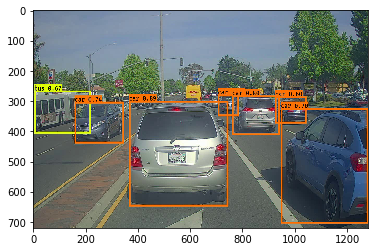

In [10]:
out_scores, out_boxes, out_classes = predict(sess, "test.jpg")

Let's generate a animation from all the images we have using matplotlib.

In [11]:
from glob import glob
from IPython.display import HTML
import matplotlib.animation as animation
%matplotlib inline

In [12]:
def animate_images():
    img_list = glob('images/*.jpg')
    frames = []
    fig = plt.figure(figsize=(15, 15))
    
    for img in img_list:
        image, image_data = preprocess_image(img, model_image_size=(608, 608))
        out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],
                                                      feed_dict={yolo_model.input:image_data, 
                                                                 K.learning_phase(): 0})
        colors = generate_colors(len(class_names))
        draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
        frames.append([plt.imshow(image, animated=True)])

    ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
    plt.show()
    
    return ani

In [ ]:
anim = animate_images()

In [14]:
anim.save('movie.mp4')

In [ ]:
HTML(anim.to_html5_video())

**Conclusions**:
- YOLO is a state-of-the-art object detection model that is fast and accurate
- It runs an input image through a CNN which outputs a 19x19x5x85 dimensional volume. 
- The encoding can be seen as a grid where each of the 19x19 cells contains information about 5 boxes.
- We filter through all the boxes using non-max suppression. Specifically: 
    - Score thresholding on the probability of detecting a class to keep only accurate (high probability) boxes
    - Intersection over Union (IoU) thresholding to eliminate overlapping boxes
- Because training a YOLO model from randomly initialized weights is non-trivial and requires a large dataset as well as lot of computation, we used previously trained model parameters.